## **Twitter Emotion Recognition using RNN**

---

[Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


## 1. Installing Hugging Face's nlp package

In [ ]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 4.3 MB/s 
     |████████████████████████████████| 243 kB 47.5 MB/s 


In [ ]:
!pip install tensorflow==2.4.0

     |████████████████████████████████| 394.7 MB 18 kB/s 
     |████████████████████████████████| 462 kB 38.7 MB/s 
     |████████████████████████████████| 132 kB 53.9 MB/s 
     |████████████████████████████████| 2.9 MB 46.6 MB/s 
     |████████████████████████████████| 3.8 MB 38.1 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68714 sha256=2de820ffd8013be1b300a3a26ff12cfd917fa47344994219167f9c5af237be39
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.43.0
    Uninstalling grpcio-1.43.0:
      Successfully uninstalled grpcio-1.43.0
  Attempting uninstall: absl-py
    Found existing install

In [ ]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(tf. __version__) 

2.4.0


# Dataset

In [ ]:
dt = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dt

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dt['train']
val = dt['validation']
test = dt['test']

In [ ]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [ ]:
tweets, labels = get_tweets(train)

In [ ]:
tweets[13], labels[13]

('i feel low energy i m just thirsty', 'sadness')

# Tokenizing

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tk = Tokenizer(num_words=10000, oov_token='<UNK>')

tk.fit_on_texts(tweets)

print(tk.texts_to_sequences([tweets[13]]))

NameError: ignored

# Padding and Truncating Sequences

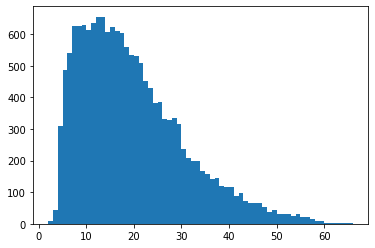

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_seq(tokenizer, tweets):
    seq = tokenizer.texts_to_sequences(tweets)
    pad_seq = pad_sequences(seq, truncating='post', maxlen=50, padding='post')
    return pad_seq

In [ ]:
pad_train_seq = get_seq(tk, tweets)

In [ ]:
pad_train_seq[10]

array([  2,   3,  14,   2,  21,   5,  80,   6, 733,   2,  93, 544, 304,
        84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Labels Preparation

In [ ]:
classes = set(labels)
print(classes)

{'love', 'joy', 'fear', 'anger', 'sadness', 'surprise'}


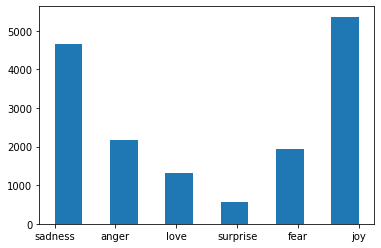

In [ ]:
plt.hist(labels, bins=11)
plt.show()

In [ ]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [ ]:
classes_to_index

{'anger': 3, 'fear': 2, 'joy': 1, 'love': 0, 'sadness': 4, 'surprise': 5}

In [ ]:
index_to_classes

{0: 'love', 1: 'joy', 2: 'fear', 3: 'anger', 4: 'sadness', 5: 'surprise'}

In [ ]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[10])

4


# Model Creation

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


# 8. Model Training

In [ ]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_seq(tk, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[13], val_labels[13]

('i was feeling sentimental', 4)

In [ ]:
h = model.fit(
    pad_train_seq, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/15
500/500 [==============================] - 45s 62ms/step - loss: 1.5079 - accuracy: 0.3815 - val_loss: 0.8044 - val_accuracy: 0.6915
Epoch 2/15
500/500 [==============================] - 29s 58ms/step - loss: 0.6326 - accuracy: 0.7489 - val_loss: 0.5761 - val_accuracy: 0.8100
Epoch 3/15
500/500 [==============================] - 30s 59ms/step - loss: 0.3628 - accuracy: 0.8765 - val_loss: 0.4263 - val_accuracy: 0.8640
Epoch 4/15
500/500 [==============================] - 30s 59ms/step - loss: 0.2189 - accuracy: 0.9308 - val_loss: 0.3575 - val_accuracy: 0.8860
Epoch 5/15
500/500 [==============================] - 29s 58ms/step - loss: 0.1509 - accuracy: 0.9537 - val_loss: 0.3893 - val_accuracy: 0.8880
Epoch 6/15
500/500 [==============================] - 29s 58ms/step - loss: 0.1164 - accuracy: 0.9633 - val_loss: 0.4012 - val_accuracy: 0.8785
Epoch 7/15
500/500 [==============================] - 29s 58ms/step - loss: 0.1050 - accuracy: 0.9671 - val_loss: 0.3947 - val_accuracy:

# Model Evaluation

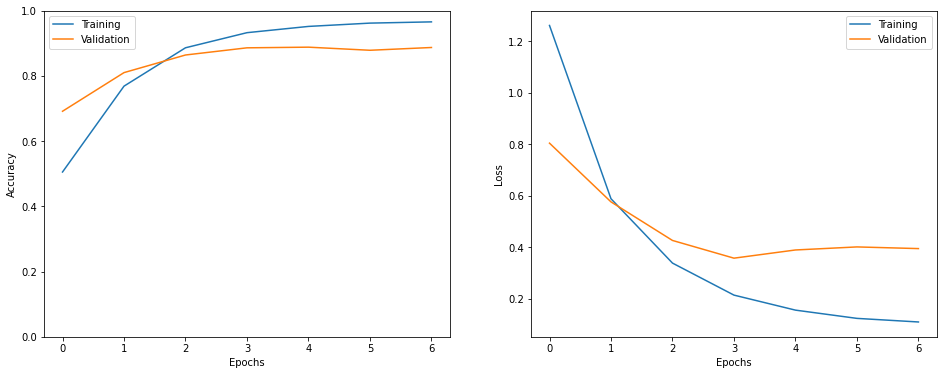

In [ ]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [ ]:
test_tweets, test_labels = get_tweets(test)
test_seq = get_seq(tk, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
eval = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 20ms/step - loss: 0.4045 - accuracy: 0.8840


In [ ]:
for a in range(0,10):
  i = random.randint(0, len(test_labels) - 1)

  print('Tweet:', test_tweets[i])
  print('Actual Emotion:', index_to_classes[test_labels[i]])

  p = model.predict_classes(np.expand_dims(test_seq[i], axis=0))[0]

  print('Predicted Emotion:', index_to_classes.get(p), '\n')

Tweet: i was cooking my dinner feeling pretty melancholy when zane lowe gave it the first spin on his radio one show on tuesday and the song matched my mood perfectly
Actual Emotion: sadness
Predicted Emotion: sadness 

Tweet: ive been feeling delicate this week
Actual Emotion: love
Predicted Emotion: love 

Tweet: i feel that he is gazing me and giving a naughty smile encouraging me to study more
Actual Emotion: love
Predicted Emotion: love 

Tweet: i feel so relaxed and happy and i have discovered that i love having projects that take a few months to do but in the end i will have an actual product to show for
Actual Emotion: joy
Predicted Emotion: joy 

Tweet: i either have to feel submissive and as such agree to taking pain for someone or there has to not be an option presented
Actual Emotion: sadness
Predicted Emotion: sadness 

Tweet: i feel like im working with half of my voice caleb and i make it through a really wonderful night at the comus inn
Actual Emotion: joy
Predicted Emo

In [ ]:
preds = model.predict_classes(test_seq)
preds.shape, test_labels.shape

((2000,), (2000,))

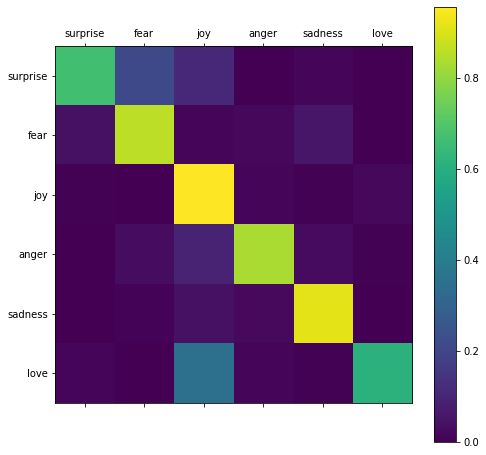

In [ ]:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
    
show_confusion_matrix(test_labels, preds, list(classes))